In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%203%20Lesson%202%20-%20RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
%matplotlib inline

2.1.0


In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 117ms/step - loss: 195.6115 - mae: 196.0721
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 194.9003 - mae: 195.2834
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 193.7610 - mae: 194.0106
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 191.7773 - mae: 192.4087
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 189.9133 - mae: 190.5219
Epoch 6/100
8/8 [==============================] - 0s 18ms/step - loss: 188.0889 - mae: 188.3526
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 185.2864 - mae: 185.8774
Epoch 8/100
8/8 [==============================] - 0s 18ms/step - loss: 182.3494 - mae: 183.0459
Epoch 9/100
8/8 [==============================] - 0s 20ms/step - loss: 179.0416 - mae: 179.8092
Epoch 10/100
8/8 [==============================] - 0s 18ms/step - loss: 175.7152 - mae: 176.0968
Epoch 11/100
8/8 [==========

Epoch 87/100
8/8 [==============================] - 0s 20ms/step - loss: 17.5993 - mae: 18.1743
Epoch 88/100
8/8 [==============================] - 0s 17ms/step - loss: 31.7432 - mae: 32.0661
Epoch 89/100
8/8 [==============================] - 0s 20ms/step - loss: 47.6547 - mae: 46.5862
Epoch 90/100
8/8 [==============================] - 0s 18ms/step - loss: 63.1371 - mae: 65.1955
Epoch 91/100
8/8 [==============================] - 0s 17ms/step - loss: 35.1726 - mae: 33.8465
Epoch 92/100
8/8 [==============================] - 0s 17ms/step - loss: 53.6004 - mae: 53.7140
Epoch 93/100
8/8 [==============================] - 0s 18ms/step - loss: 49.1677 - mae: 48.9714
Epoch 94/100
8/8 [==============================] - 0s 16ms/step - loss: 41.4282 - mae: 40.2066
Epoch 95/100
8/8 [==============================] - 0s 17ms/step - loss: 45.4201 - mae: 46.0115
Epoch 96/100
8/8 [==============================] - 0s 18ms/step - loss: 61.0934 - mae: 62.0079
Epoch 97/100
8/8 [======================

(1e-08, 0.0001, 0.0, 30.0)

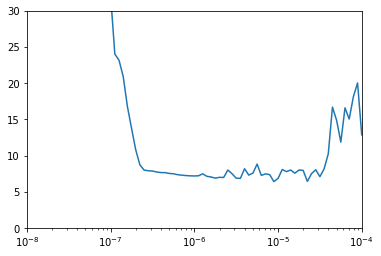

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 1s 119ms/step - loss: 81.1158 - mae: 83.5783
Epoch 2/400
8/8 [==============================] - 0s 17ms/step - loss: 23.6082 - mae: 24.3853
Epoch 3/400
8/8 [==============================] - 0s 17ms/step - loss: 18.2199 - mae: 18.7075
Epoch 4/400
8/8 [==============================] - 0s 17ms/step - loss: 14.1505 - mae: 14.6785
Epoch 5/400
8/8 [==============================] - 0s 17ms/step - loss: 10.7215 - mae: 11.2669
Epoch 6/400
8/8 [==============================] - 0s 17ms/step - loss: 12.3707 - mae: 12.5364
Epoch 7/400
8/8 [==============================] - 0s 18ms/step - loss: 12.6145 - mae: 13.1619
Epoch 8/400
8/8 [==============================] - 0s 17ms/step - loss: 11.9541 - mae: 12.5568
Epoch 9/400
8/8 [==============================] - 0s 18ms/step - loss: 12.8154 - mae: 13.5448
Epoch 10/400
8/8 [==============================] - 0s 17ms/step - loss: 13.7515 - mae: 14.4417
Epoch 11/400
8/8 [==============================

8/8 [==============================] - 0s 17ms/step - loss: 5.0321 - mae: 5.5527
Epoch 88/400
8/8 [==============================] - 0s 18ms/step - loss: 5.1504 - mae: 5.6495
Epoch 89/400
8/8 [==============================] - 0s 18ms/step - loss: 4.8779 - mae: 5.3742
Epoch 90/400
8/8 [==============================] - 0s 18ms/step - loss: 5.0349 - mae: 5.5361
Epoch 91/400
8/8 [==============================] - 0s 18ms/step - loss: 5.0362 - mae: 5.5635
Epoch 92/400
8/8 [==============================] - 0s 17ms/step - loss: 5.3167 - mae: 5.8017
Epoch 93/400
8/8 [==============================] - 0s 17ms/step - loss: 4.7273 - mae: 5.1827
Epoch 94/400
8/8 [==============================] - 0s 17ms/step - loss: 5.4695 - mae: 5.8448
Epoch 95/400
8/8 [==============================] - 0s 17ms/step - loss: 5.6684 - mae: 6.1097
Epoch 96/400
8/8 [==============================] - 0s 17ms/step - loss: 5.6607 - mae: 6.1820
Epoch 97/400
8/8 [==============================] - 0s 16ms/step - loss: 

8/8 [==============================] - 0s 20ms/step - loss: 6.1624 - mae: 6.6351
Epoch 174/400
8/8 [==============================] - 0s 21ms/step - loss: 7.2288 - mae: 7.7589
Epoch 175/400
8/8 [==============================] - 0s 18ms/step - loss: 5.9161 - mae: 6.4039
Epoch 176/400
8/8 [==============================] - 0s 18ms/step - loss: 4.6686 - mae: 5.1687
Epoch 177/400
8/8 [==============================] - 0s 18ms/step - loss: 4.7495 - mae: 5.2107
Epoch 178/400
8/8 [==============================] - 0s 18ms/step - loss: 4.5478 - mae: 5.0328
Epoch 179/400
8/8 [==============================] - 0s 18ms/step - loss: 4.9123 - mae: 5.3468
Epoch 180/400
8/8 [==============================] - 0s 18ms/step - loss: 4.8685 - mae: 5.3689
Epoch 181/400
8/8 [==============================] - 0s 17ms/step - loss: 4.6167 - mae: 5.1092
Epoch 182/400
8/8 [==============================] - 0s 20ms/step - loss: 4.8616 - mae: 5.3530
Epoch 183/400
8/8 [==============================] - 0s 21ms/ste

8/8 [==============================] - 0s 21ms/step - loss: 4.4026 - mae: 4.8678
Epoch 260/400
8/8 [==============================] - 0s 18ms/step - loss: 4.6972 - mae: 5.1839
Epoch 261/400
8/8 [==============================] - 0s 18ms/step - loss: 4.8340 - mae: 5.3174
Epoch 262/400
8/8 [==============================] - 0s 22ms/step - loss: 4.5895 - mae: 5.0225
Epoch 263/400
8/8 [==============================] - 0s 18ms/step - loss: 4.2082 - mae: 4.6750
Epoch 264/400
8/8 [==============================] - 0s 18ms/step - loss: 4.6351 - mae: 5.1177
Epoch 265/400
8/8 [==============================] - 0s 18ms/step - loss: 4.8037 - mae: 5.2582
Epoch 266/400
8/8 [==============================] - 0s 17ms/step - loss: 4.7089 - mae: 5.1989
Epoch 267/400
8/8 [==============================] - 0s 18ms/step - loss: 4.3415 - mae: 4.8394
Epoch 268/400
8/8 [==============================] - 0s 18ms/step - loss: 4.2697 - mae: 4.7667
Epoch 269/400
8/8 [==============================] - 0s 18ms/ste

Epoch 345/400
8/8 [==============================] - 0s 18ms/step - loss: 5.0502 - mae: 5.5387
Epoch 346/400
8/8 [==============================] - 0s 17ms/step - loss: 4.7616 - mae: 5.2307
Epoch 347/400
8/8 [==============================] - 0s 17ms/step - loss: 4.4664 - mae: 4.9103
Epoch 348/400
8/8 [==============================] - 0s 17ms/step - loss: 5.4250 - mae: 5.8734
Epoch 349/400
8/8 [==============================] - 0s 17ms/step - loss: 5.6323 - mae: 6.0367
Epoch 350/400
8/8 [==============================] - 0s 18ms/step - loss: 5.5913 - mae: 6.0833
Epoch 351/400
8/8 [==============================] - 0s 17ms/step - loss: 5.0659 - mae: 5.5504
Epoch 352/400
8/8 [==============================] - 0s 17ms/step - loss: 5.3077 - mae: 5.8015
Epoch 353/400
8/8 [==============================] - 0s 17ms/step - loss: 4.8220 - mae: 5.3042
Epoch 354/400
8/8 [==============================] - 0s 18ms/step - loss: 4.9289 - mae: 5.3117
Epoch 355/400
8/8 [==============================]

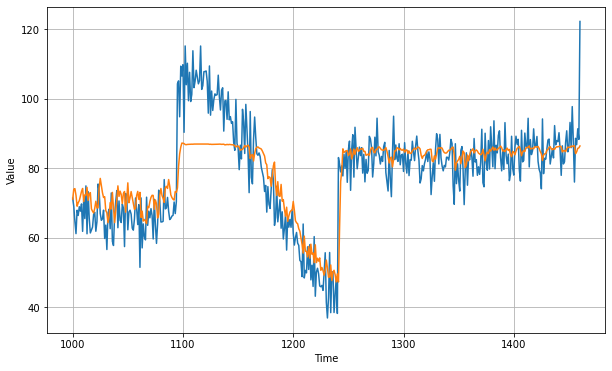

In [9]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.481728

<Figure size 432x288 with 0 Axes>

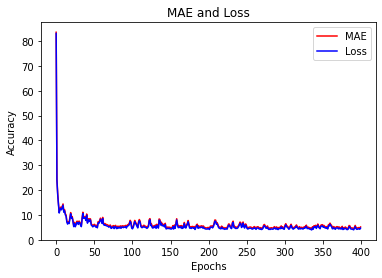

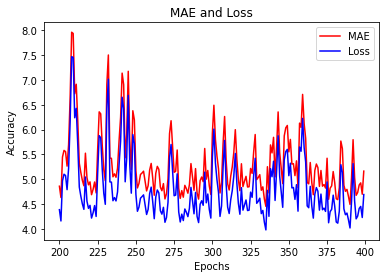

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()